# Visualise Results
This Notebook downloads experiment data from comet-ml and aggregates or visualises them for the thesis.

In [1]:
from comet_ml.api import API
import comet_ml
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18


# Initialize the Comet API with API key
api_key = "GAzEuNsoYVpPXO2ryeTk7C1o7"
api = API(api_key=api_key)

In [2]:
def get_experiments_results_data(workspace, project_name, experiment_ids):
    # Get the list of experiments in the project
    result_data = []
    for k, v in experiment_ids.items():
        experiment = api.get(workspace=workspace,
                             project_name=project_name, experiment=v)
        print(experiment.id)
        print(experiment.name)
        # You can also fetch individual metrics, parameters, etc.
        metrics_valid_mrr = experiment.get_metrics(["valid_mrr"])
        metrics_test_mrr = experiment.get_metrics(["test_mrr"])
        max_valid_mrr_value = float('-inf')
        max_epoch = None

        for record in metrics_valid_mrr:
            metric_value = float(record['metricValue'])
            if metric_value > max_valid_mrr_value:
                max_valid_mrr_value = metric_value
                max_epoch = record['epoch']

        print(f"Max valid_mrr: {max_valid_mrr_value}, Epoch: {max_epoch}")
        for record in metrics_test_mrr:
            if record['epoch'] == max_epoch:
                metric_test_mrr_epoch = float(record['metricValue'])
                break
        print(f"Max test_mrr: {metric_test_mrr_epoch}, Epoch: {max_epoch}")

        result_data.append({"name": k, "key": experiment.id, "max_valid_mrr": max_valid_mrr_value,
                           "test_mrr": metric_test_mrr_epoch, "epoch": max_epoch})

    return result_data


def plot_training_curves(df_mrr, title="MRR Curves", visualize_test_mrr=True):
    plt.figure(figsize=(10, 6))
    if visualize_test_mrr:
        sns.lineplot(df_mrr[df_mrr["metricName"] == "test_mrr"], x="epoch",
                     y="metricValue", label="test_mrr", linestyle="dashed", color="red", alpha=0.7)
    sns.lineplot(df_mrr[df_mrr["metricName"] == "train_mrr"],
                 x="epoch", y="metricValue", label="train_mrr", color="green")
    sns.lineplot(df_mrr[df_mrr["metricName"] == "valid_mrr"],
                 x="epoch", y="metricValue", label="valid_mrr", color="blue")

    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('MRR')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_training_curves_loss_auc(df_mrr, title="MRR Curves", y_axis="Metrics", ):
    plt.figure(figsize=(10, 6))
    sns.lineplot(df_mrr[df_mrr["metricName"] == "train_mrr"],
                 x="epoch", y="metricValue", label="Train MRR", color="blue")
    sns.lineplot(df_mrr[df_mrr["metricName"] == "train_rocauc"],
                 x="epoch", y="metricValue", label="AUROC", color="orange")
    sns.lineplot(df_mrr[df_mrr["metricName"] == "loss_epoch"], x="epoch",
                 y="metricValue", label="Negative-Log-\nLikelihood-Loss", color="green")

    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend()
    plt.show()
def get_experiments_data(workspace, project_name, experiment_ids, other_losses=False, epoch_loss=False):
    # Get the list of experiments in the project
    metrics_data = []
    for k, v in experiment_ids.items():
        experiment = api.get(workspace=workspace,
                             project_name=project_name, experiment=v)
        print(experiment.id)
        print(experiment.name)
        # You can also fetch individual metrics, parameters, etc.
        train_mrr = pd.DataFrame(experiment.get_metrics("train_mrr"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]
        valid_mrr = pd.DataFrame(experiment.get_metrics("valid_mrr"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]
        test_mrr = pd.DataFrame(experiment.get_metrics("test_mrr"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]
        train_loss = pd.DataFrame(experiment.get_metrics("loss_epoch"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]

        if other_losses:
            valid_loss = pd.DataFrame(experiment.get_metrics("valid_loss"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            test_loss = pd.DataFrame(experiment.get_metrics("test_loss"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            metrics = pd.concat(
                [train_mrr, valid_mrr, test_mrr, train_loss, valid_loss, test_loss])
        elif epoch_loss:
            epoch_loss = pd.DataFrame(experiment.get_metrics("loss_epoch"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            auc = pd.DataFrame(experiment.get_metrics("train_rocauc"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            metrics = pd.concat(
                [train_mrr, valid_mrr, test_mrr, epoch_loss, auc])
        else:
            metrics = pd.concat([train_mrr, valid_mrr, test_mrr, train_loss])
        metrics_data.append(
            {"name": k, "key": experiment.id, "metrics": metrics})
    return metrics_data

## Reproduction Models
Model data for reproduction models is downloaded and visualised.

In [3]:
experiment_ids = {'reproduction_ogbl-citation2_repo_parameter':'832b085db0fb4fc6802da9b714c86072',}
workspace = "link-prediction-reproduction"
project_name = "link-prediction-reproduction"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids,epoch_loss=True)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

832b085db0fb4fc6802da9b714c86072
reproduction_ogbl-citation2_repo_parameter
832b085db0fb4fc6802da9b714c86072
reproduction_ogbl-citation2_repo_parameter
Max valid_mrr: 0.6953060030937195, Epoch: 48
Max test_mrr: 0.6962698101997375, Epoch: 48


### Mean Difference Validation and Train MRR
Calculate the mean difference from validation to train MRR.

In [4]:
df_repro_val_train_mrr = experiment_data[0]['metrics']
df_repro_val_train_mrr = df_repro_val_train_mrr[df_repro_val_train_mrr["metricName"].isin(["train_mrr", "valid_mrr"])]
np.round(np.mean(np.array(df_repro_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'], dtype=float) - np.array(
    df_repro_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'], dtype=float)), 4)

-0.0787

### Plot AUROC, MRR and NLL-Loss
Plot AUROC, MRR and NLL-Loss together into a single visualisation.

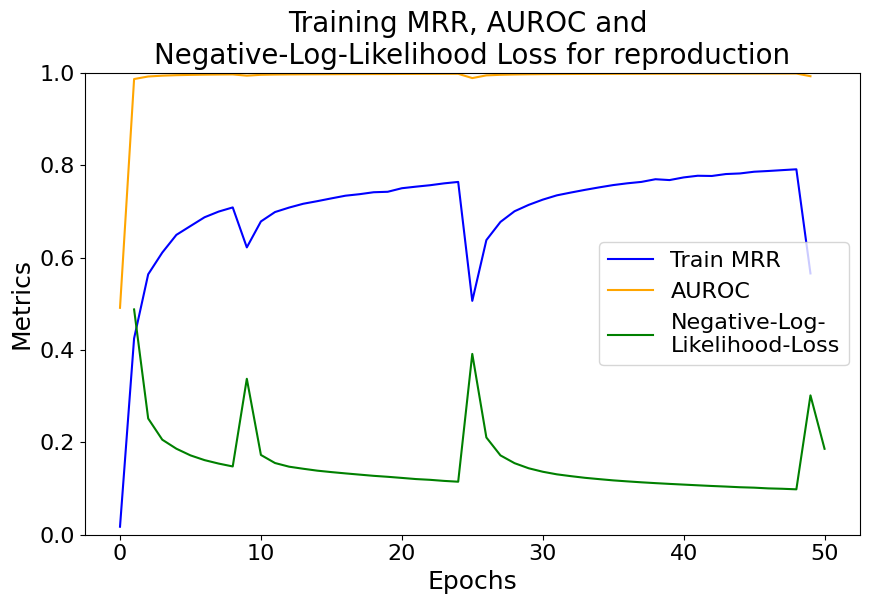

In [5]:
repro_df = experiment_data[0]['metrics']
repro_df['metricValue'] = repro_df['metricValue'].astype(float)
plot_training_curves_loss_auc(repro_df, "Training MRR, AUROC and \nNegative-Log-Likelihood Loss for reproduction")

## Reference Models
Model data for reference models (gcn and ngcn) is downloaded and visualised.

In [6]:
experiment_ids = {'GCN arXiv CS reference':'c4f5985ba24e4c93b569dde82ce15a78',
                  'NGCN arXiv CS reference':'d45ca57aa4d84332abe8a2a994302ca1'}
workspace = "swiggy123"
project_name = "link-prediction"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

c4f5985ba24e4c93b569dde82ce15a78
arxiv_base_gcn_long_2
d45ca57aa4d84332abe8a2a994302ca1
arxiv_base_ngnn_long
c4f5985ba24e4c93b569dde82ce15a78
arxiv_base_gcn_long_2
Max valid_mrr: 0.8499453663825989, Epoch: 2071
Max test_mrr: 0.8478335738182068, Epoch: 2071
d45ca57aa4d84332abe8a2a994302ca1
arxiv_base_ngnn_long
Max valid_mrr: 0.8721627593040466, Epoch: 1983
Max test_mrr: 0.8653520941734314, Epoch: 1983


In [7]:
# MODELSELECTION for GCN arXiv CS reference
df_ = experiment_data[0]['metrics']
df_[(df_['epoch'].isin([2070,2080])) & (df_['metricName'] == "valid_mrr")]

,metricName,metricValue,epoch,timestamp
2070,valid_mrr,0.8469447493553162,2070,1719049514522
2080,valid_mrr,0.8438994884490967,2080,1719049909384


In [8]:

# get best 
gcn_df = experiment_data[0]['metrics']

firstepoch_test_mrr_gcn_ref = float(gcn_df[gcn_df['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_gcn_ref = float(gcn_df[gcn_df['metricName'] == "test_mrr"].iloc[2071]['metricValue'])

ngcn_df = experiment_data[1]['metrics']

firstepoch_test_mrr_ngcn_ref = float(ngcn_df[ngcn_df['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_ngcn_ref = float(ngcn_df[ngcn_df['metricName'] == "test_mrr"].iloc[1983]['metricValue'])

### Mean Difference Validation and Train MRR
Calculate the mean difference from validation to train MRR.

In [9]:
df_ref_val_train_mrr =experiment_data[0]['metrics']
df_ref_val_train_mrr = df_ref_val_train_mrr[df_ref_val_train_mrr["metricName"].isin(["train_mrr","valid_mrr"])]
np.round(np.mean(np.array(df_ref_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'],dtype=float) - np.array(df_ref_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'],dtype=float)),4)


0.1581

### Plot MRR Curves
Plot MRR Curves together into a single visualisation.

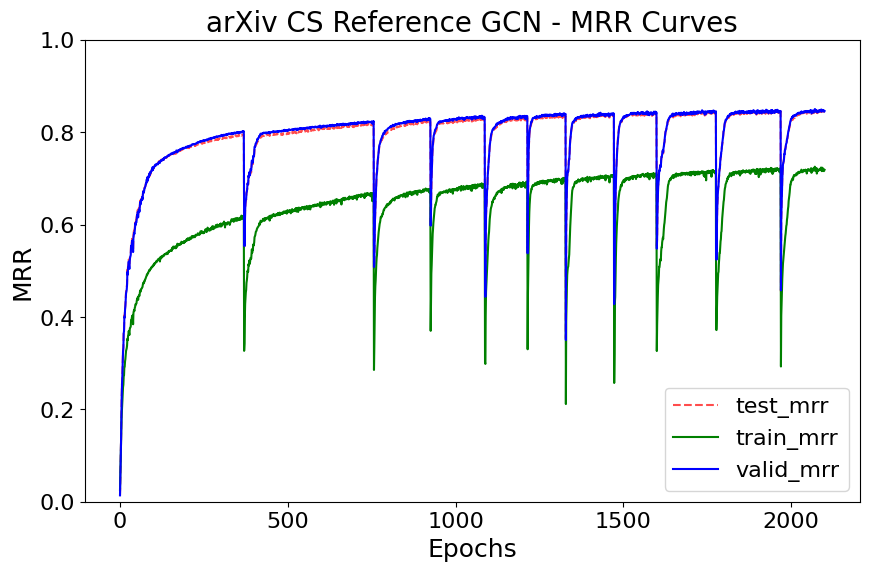

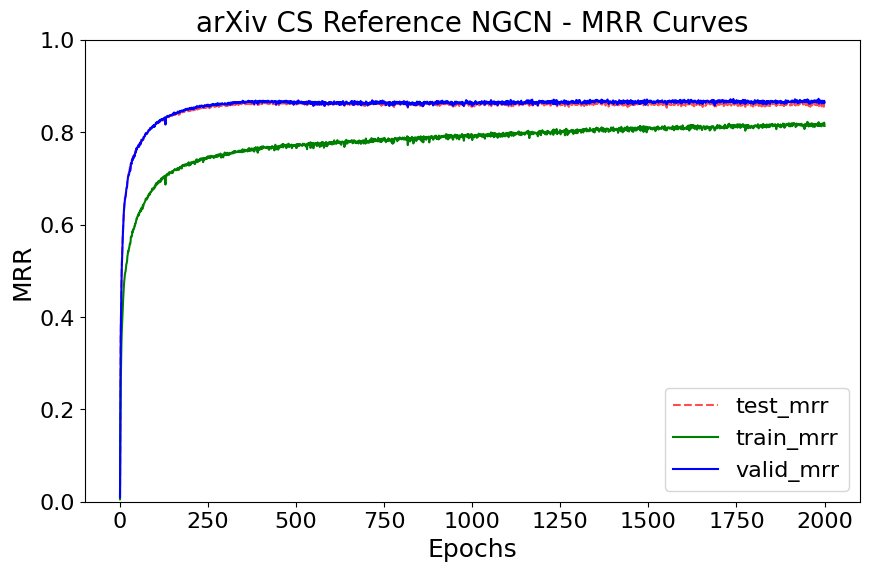

In [10]:
gcn_df['metricValue'] = gcn_df['metricValue'].astype(float)
ngcn_df['metricValue'] = ngcn_df['metricValue'].astype(float)
plot_training_curves(gcn_df, "arXiv CS Reference GCN - MRR Curves")
plot_training_curves(ngcn_df, "arXiv CS Reference NGCN - MRR Curves")

## Pretrain Models
Model data for Pretrain models is downloaded and visualised.

In [11]:
experiment_ids = {'GCN arXiv w/o CS Pretraining':'23f4e7d8ec4c40f6a9852a33808a4515',
                  'NGCN arXiv w/o CS Pretraining':'d3ca1509073d4ce3999cad340d610cb3'}

workspace = "swiggy123"
project_name = "link-prediction-pretraining"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

23f4e7d8ec4c40f6a9852a33808a4515
papers100M_training_layer_1_longer
d3ca1509073d4ce3999cad340d610cb3
papers100M_ngnn_training_longer
23f4e7d8ec4c40f6a9852a33808a4515
papers100M_training_layer_1_longer
Max valid_mrr: 0.8120094537734985, Epoch: 199
Max test_mrr: 0.81381756067276, Epoch: 199
d3ca1509073d4ce3999cad340d610cb3
papers100M_ngnn_training_longer
Max valid_mrr: 0.8117884993553162, Epoch: 178
Max test_mrr: 0.8087790012359619, Epoch: 178


### Mean Difference Validation and Train MRR
Calculate the mean difference from validation to train MRR.

In [12]:
df_pretrain_val_train_mrr =experiment_data[0]['metrics']
df_pretrain_val_train_mrr = df_pretrain_val_train_mrr[df_pretrain_val_train_mrr["metricName"].isin(["train_mrr","valid_mrr"])]
np.round(np.mean(np.array(df_pretrain_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'],dtype=float) - np.array(df_pretrain_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'],dtype=float)),4)


0.0122

In [13]:
# MODELSELECTION for GCN arXiv w/o CS Pretraining
df_ = experiment_data[0]['metrics']
df_[(df_['epoch'].isin([200,195])) & (df_['metricName'] == "valid_mrr")]

,metricName,metricValue,epoch,timestamp
195,valid_mrr,0.8109702467918396,195,1716642935592
200,valid_mrr,0.8119358420372009,200,1716646868946


In [14]:
# MODELSELECTION for NGCN arXiv w/o CS Pretraining
df_ = experiment_data[1]['metrics']
df_[(df_['epoch'].isin([180,175])) & (df_['metricName'] == "valid_mrr")]

,metricName,metricValue,epoch,timestamp
175,valid_mrr,0.8072109818458557,175,1717941635998
180,valid_mrr,0.8080305457115173,180,1717946623291


### Mean Difference Validation and Train MRR
Calculate the mean difference from validation to train MRR.

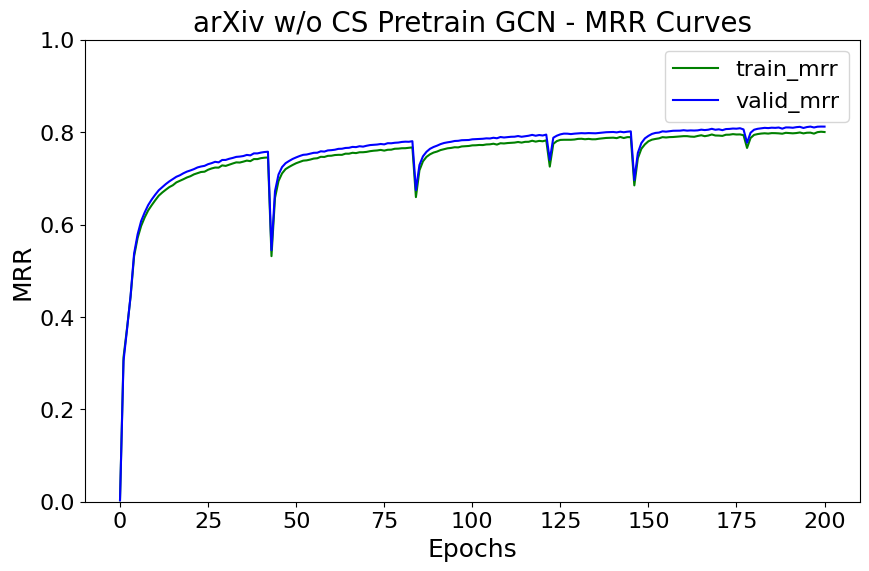

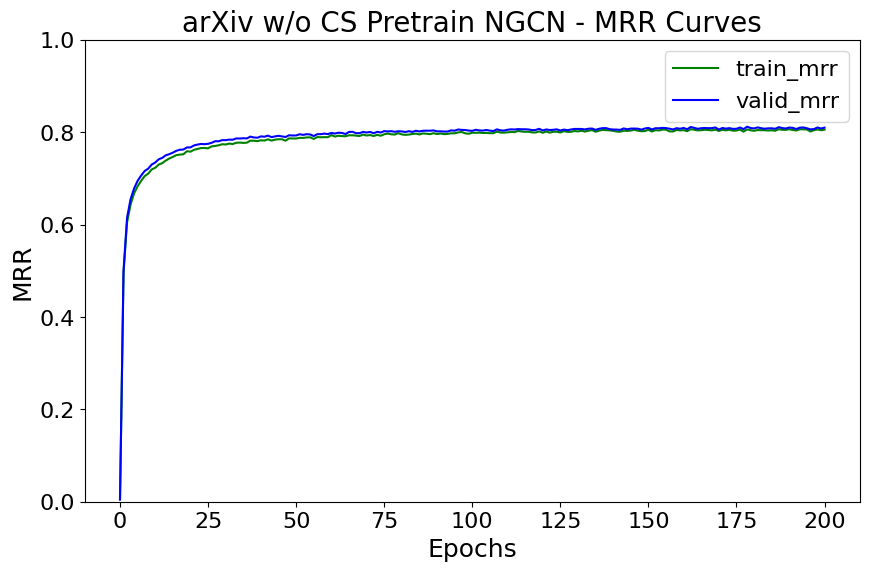

In [15]:
gcn_df_pretrain = experiment_data[0]['metrics']
ngcn_df_pretrain = experiment_data[1]['metrics']

gcn_df_pretrain['metricValue'] = gcn_df_pretrain['metricValue'].astype(float)
ngcn_df_pretrain['metricValue'] = ngcn_df_pretrain['metricValue'].astype(float)
plot_training_curves(gcn_df_pretrain, "arXiv w/o CS Pretrain GCN - MRR Curves",False)
plot_training_curves(ngcn_df_pretrain, "arXiv w/o CS Pretrain NGCN - MRR Curves",False)

## Finetuning Models
Model data for Finetuning models is downloaded and visualised.

In [16]:
experiment_ids = {'GCN arXiv CS Finetuning':'50b1b190160c4e1185fca9d8f815d83a',
                  'NGCN arXiv CS Finetuning':'ddfef4f15cc34101b030dabcd970aed8'}
workspace = "swiggy123"
project_name = "link-prediction-finetuning"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

50b1b190160c4e1185fca9d8f815d83a
finetune_tuned_gcn
ddfef4f15cc34101b030dabcd970aed8
arxiv_ngnn-finetuned_tuned_gcn
50b1b190160c4e1185fca9d8f815d83a
finetune_tuned_gcn
Max valid_mrr: 0.8672634363174438, Epoch: 1896
Max test_mrr: 0.8653174638748169, Epoch: 1896
ddfef4f15cc34101b030dabcd970aed8
arxiv_ngnn-finetuned_tuned_gcn
Max valid_mrr: 0.8635789752006531, Epoch: 1397
Max test_mrr: 0.8593466281890869, Epoch: 1397


### Mean Difference Validation and Train MRR
Calculate the mean difference from validation to train MRR.

In [17]:
df_fine_val_train_mrr =experiment_data[0]['metrics']
df_fine_val_train_mrr = df_fine_val_train_mrr[df_fine_val_train_mrr["metricName"].isin(["train_mrr","valid_mrr"])]
np.round(np.mean(np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'],dtype=float) - np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'],dtype=float)),4)


0.1326

In [18]:
# MODELSELECTION for GCN arXiv CS Finetuning
df_ = experiment_data[0]['metrics']
df_[(df_['epoch'].isin([1900,1800])) & (df_['metricName'] == "valid_mrr")]

,metricName,metricValue,epoch,timestamp
1801,valid_mrr,0.8567351698875427,1800,1718345866523
1901,valid_mrr,0.8661572337150574,1900,1718349858419


In [19]:
# MODELSELECTION for NGCN arXiv CS Finetuning
df_ = experiment_data[1]['metrics']
df_[(df_['epoch'].isin([1900,1800])) & (df_['metricName'] == "valid_mrr")]

,metricName,metricValue,epoch,timestamp
1857,valid_mrr,0.854942262172699,1800,1718950734495


### Plot MRR Curves
Plot MRR Curves together into a single visualisation.

In [20]:
gcn_df_fine = experiment_data[0]['metrics']
firstepoch_test_mrr_gcn_fine = float(gcn_df_fine[gcn_df_fine['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_gcn_fine = float(gcn_df_fine[gcn_df_fine['metricName'] == "test_mrr"].iloc[1896]['metricValue'])

ngcn_df_fine = experiment_data[1]['metrics']
firstepoch_test_mrr_ngcn_fine = float(ngcn_df_fine[ngcn_df_fine['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_ngcn_fine = float(ngcn_df_fine[ngcn_df_fine['metricName'] == "test_mrr"].iloc[1397]['metricValue'])


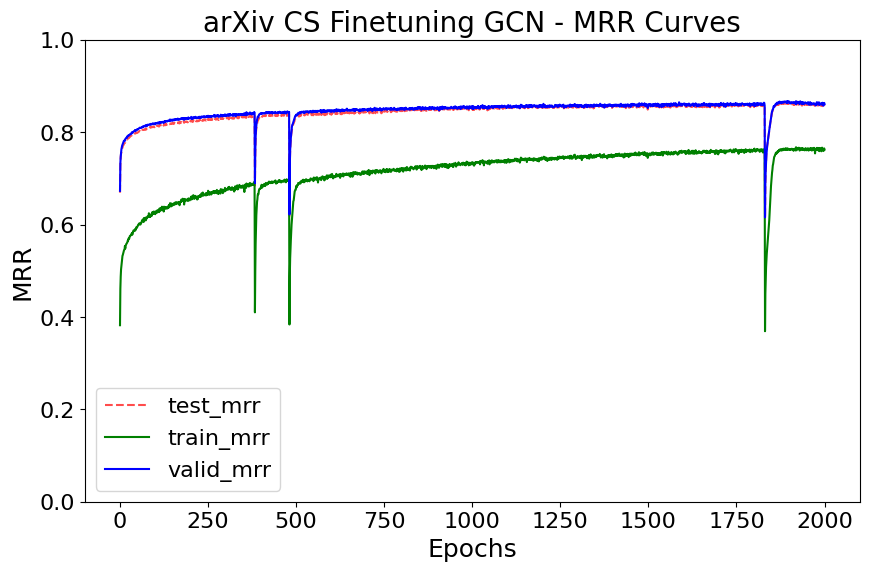

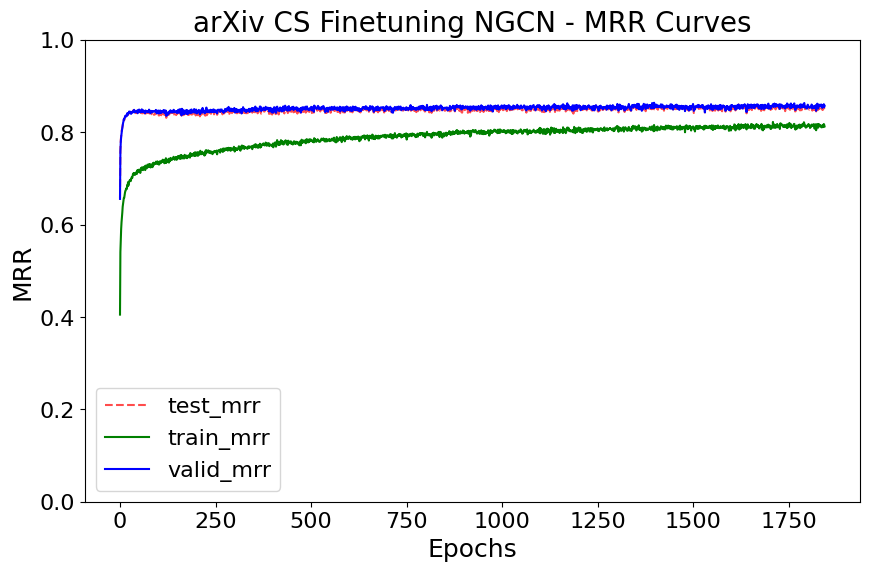

In [21]:
gcn_df_fine['metricValue'] = gcn_df_fine['metricValue'].astype(float)
ngcn_df_fine['metricValue'] = ngcn_df_fine['metricValue'].astype(float)
plot_training_curves(gcn_df_fine, "arXiv CS Finetuning GCN - MRR Curves")
plot_training_curves(ngcn_df_fine, "arXiv CS Finetuning NGCN - MRR Curves")

## Compute Time Differences GCN Reference / Finetune
Computing time differences between the reference and finetuned model

In [22]:
gcn_df['timestamp'] = gcn_df['timestamp']/1000
gcn_df['timestamp'] = pd.to_datetime(gcn_df['timestamp'], unit='s')
gcn_df['minute_diff'] = (gcn_df['timestamp'] - gcn_df['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

gcn_df_fine['timestamp'] = gcn_df_fine['timestamp']/1000
gcn_df_fine['timestamp'] = pd.to_datetime(gcn_df_fine['timestamp'], unit='s')
gcn_df_fine['minute_diff'] = (gcn_df_fine['timestamp'] - gcn_df_fine['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

ngcn_df['timestamp'] = ngcn_df['timestamp']/1000
ngcn_df['timestamp'] = pd.to_datetime(ngcn_df['timestamp'], unit='s')
ngcn_df['minute_diff'] = (ngcn_df['timestamp'] - ngcn_df['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

ngcn_df_fine['timestamp'] = ngcn_df_fine['timestamp']/1000
ngcn_df_fine['timestamp'] = pd.to_datetime(ngcn_df_fine['timestamp'], unit='s')
ngcn_df_fine['minute_diff'] = (ngcn_df_fine['timestamp'] - ngcn_df_fine['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

In [23]:
# get training step where the reference model was the first time over 10 hours (GCN)
gcn_df_test_mrr = gcn_df[gcn_df['metricName'] == "test_mrr"]
gcn_df_test_mrr[gcn_df_test_mrr['minute_diff'] <=10.01][-1:]


,metricName,metricValue,epoch,timestamp,minute_diff
904,test_mrr,0.823472,904,2024-06-21 20:40:04.634000063,10.006884


In [24]:
# get training step where the reference model was the first time over 10 hours (NGCN)
ngcn_df_test_mrr = ngcn_df[ngcn_df['metricName'] == "test_mrr"]
ngcn_df_test_mrr[ngcn_df_test_mrr['minute_diff'] <=10.01][-1:]


,metricName,metricValue,epoch,timestamp,minute_diff
845,test_mrr,0.860385,837,2024-06-14 22:30:45.596999884,10.007598


In [25]:
# get training step where the finetuned model is as close as possible to the mrr of the above training step (GCN)
gcn_df_fine_test_mrr = gcn_df_fine[gcn_df_fine['metricName'] == "test_mrr"]
gcn_df_fine_test_mrr[gcn_df_fine_test_mrr['metricValue'] >= 0.823472][:1]

,metricName,metricValue,epoch,timestamp,minute_diff
194,test_mrr,0.824514,194,2024-06-13 12:14:12.664000034,2.267009


In [26]:
# get training step where the finetuned model is as close as possible to the mrr of the above training step (NGCN)
ngcn_df_fine_test_mrr = ngcn_df_fine[ngcn_df_fine['metricName'] == "test_mrr"]
ngcn_df_fine_test_mrr[ngcn_df_fine_test_mrr['metricValue'] >= 0.860385]

,metricName,metricValue,epoch,timestamp,minute_diff


### Plotting the training time
Plotting the training time and especially the intersection points for the equivalent metrics.


C:\Users\Tom\AppData\Local\Temp\ipykernel_22596\3594899013.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(10,0.823472,'ro', markersize=7,color="blue", markeredgecolor='black', label='Reference - 10 Hour Training')
C:\Users\Tom\AppData\Local\Temp\ipykernel_22596\3594899013.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(2.267009,0.823030,'ro', markersize=7,color="red", markeredgecolor='black', label='Finetuning - Intersection Point')


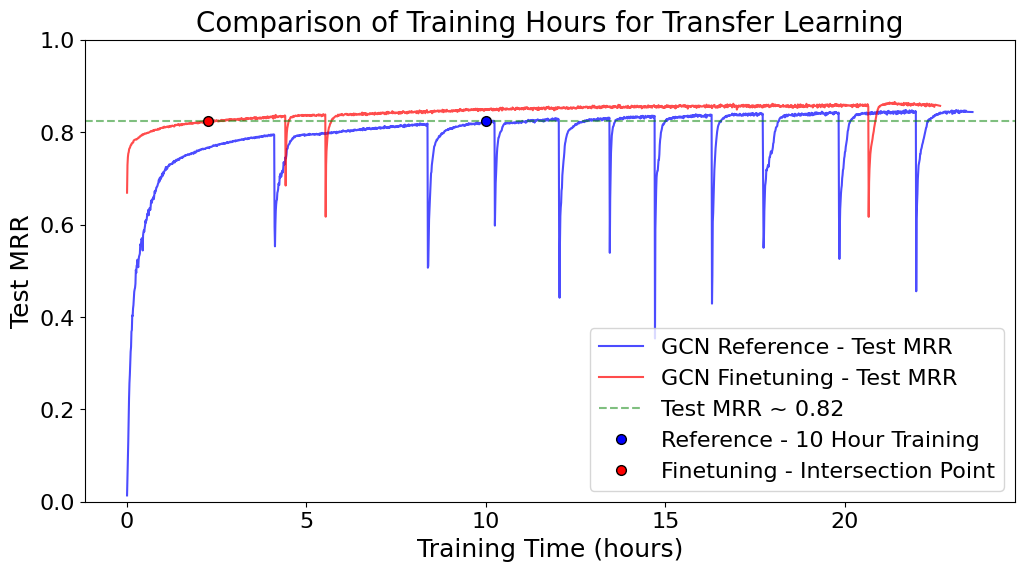

In [27]:
sns.lineplot(gcn_df[gcn_df["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="GCN Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(gcn_df_fine[gcn_df_fine["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="GCN Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Training Time (hours)')
plt.ylabel('Test MRR')
plt.title("Comparison of Training Hours for Transfer Learning")
plt.axhline(0.823472,alpha=0.5,color="green",linestyle="dashed",label="Test MRR ~ 0.82")
plt.plot(10,0.823472,'ro', markersize=7,color="blue", markeredgecolor='black', label='Reference - 10 Hour Training')
plt.plot(2.267009,0.823030,'ro', markersize=7,color="red", markeredgecolor='black', label='Finetuning - Intersection Point')
plt.legend()

plt.show()

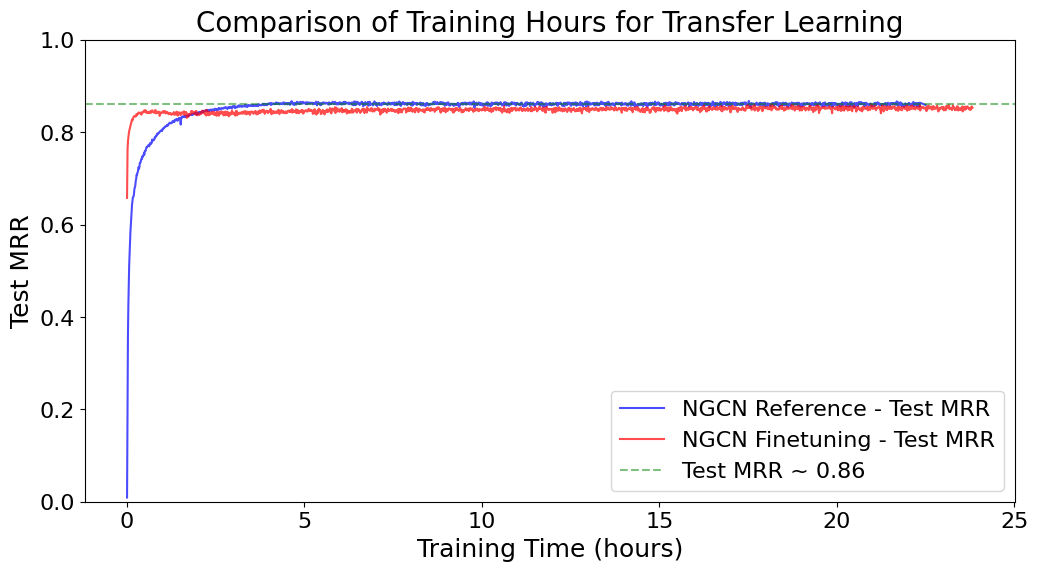

In [28]:
sns.lineplot(ngcn_df[ngcn_df["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="NGCN Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(ngcn_df_fine[ngcn_df_fine["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="NGCN Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Training Time (hours)')
plt.ylabel('Test MRR')
plt.title("Comparison of Training Hours for Transfer Learning")
plt.axhline(0.860385,alpha=0.5,color="green",linestyle="dashed",label="Test MRR ~ 0.86")
plt.legend()

plt.show()

## Standard Deviation Reference Models
Calculation of the standard deviation (model variability) of the gcn reference models.

In [29]:
# get all results
experiment_ids = {'GCN arXiv CS Ref 1':'f48a4e67ea8846a0b3d2ca7e674aca95',
                  'GCN arXiv CS Ref 2':'c4f5985ba24e4c93b569dde82ce15a78',
                  'GCN arXiv CS Ref 3':'942c73672d59449c8a051796ae7f0e49',
                  'GCN arXiv CS Ref 4':'54dba56b65814a4fb588b03d32d61cf6',
                  'GCN arXiv CS Ref 5':'38ea03024c92483aabcf420fa960d293',
                  }
workspace = "swiggy123"
project_name = "link-prediction"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

f48a4e67ea8846a0b3d2ca7e674aca95
train_longer_after_hypetuning_middle_lr
c4f5985ba24e4c93b569dde82ce15a78
arxiv_base_gcn_long_2
942c73672d59449c8a051796ae7f0e49
arxiv_base_gcn_long
54dba56b65814a4fb588b03d32d61cf6
arxiv_base_gcn_long_1
38ea03024c92483aabcf420fa960d293
arxiv_base_gcn_long_3
f48a4e67ea8846a0b3d2ca7e674aca95
train_longer_after_hypetuning_middle_lr
Max valid_mrr: 0.8484336733818054, Epoch: 2068
Max test_mrr: 0.844505250453949, Epoch: 2068
c4f5985ba24e4c93b569dde82ce15a78
arxiv_base_gcn_long_2
Max valid_mrr: 0.8499453663825989, Epoch: 2071
Max test_mrr: 0.8478335738182068, Epoch: 2071
942c73672d59449c8a051796ae7f0e49
arxiv_base_gcn_long
Max valid_mrr: 0.8459517359733582, Epoch: 1637
Max test_mrr: 0.8422207236289978, Epoch: 1637
54dba56b65814a4fb588b03d32d61cf6
arxiv_base_gcn_long_1
Max valid_mrr: 0.8498203158378601, Epoch: 2054
Max test_mrr: 0.8466485142707825, Epoch: 2054
38ea03024c92483aabcf420fa960d293
arxiv_base_gcn_long_3
Max valid_mrr: 0.8487957119941711, Epoch: 2029


In [30]:
# best values from above
valid_mrr_values = [0.8484336733818054, 0.8499453663825989, 0.8459517359733582, 0.8498203158378601, 0.8487957119941711]
test_mrr_values = [0.844505250453949, 0.8478335738182068, 0.8422207236289978, 0.8466485142707825, 0.8474210500717163]
valid_mrr_mean = np.round(np.mean(valid_mrr_values),4)
valid_mrr_std = np.round(np.std(valid_mrr_values),4)
test_mrr_mean = np.round(np.mean(test_mrr_values),4)
test_mrr_std = np.round(np.std(test_mrr_values),4)

# get mean valid and test mrr for the 5 runs
print(f"Valid mean MRR: {valid_mrr_mean} ({valid_mrr_std})")
print(f"Test mean MRR: {test_mrr_mean} ({test_mrr_std})")

Valid mean MRR: 0.8486 (0.0014)
Test mean MRR: 0.8457 (0.0021)


In [31]:
# get train val mrr difference over all epochs per run
for i in range(0,5):
    df_fine_val_train_mrr = experiment_data[i]['metrics']
    df_fine_val_train_mrr = df_fine_val_train_mrr[df_fine_val_train_mrr["metricName"].isin(["train_mrr","valid_mrr"])]
    print(np.round(np.mean(np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'],dtype=float) - np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'],dtype=float)),4))


0.1624
0.1581
0.1646
0.1639
0.1651


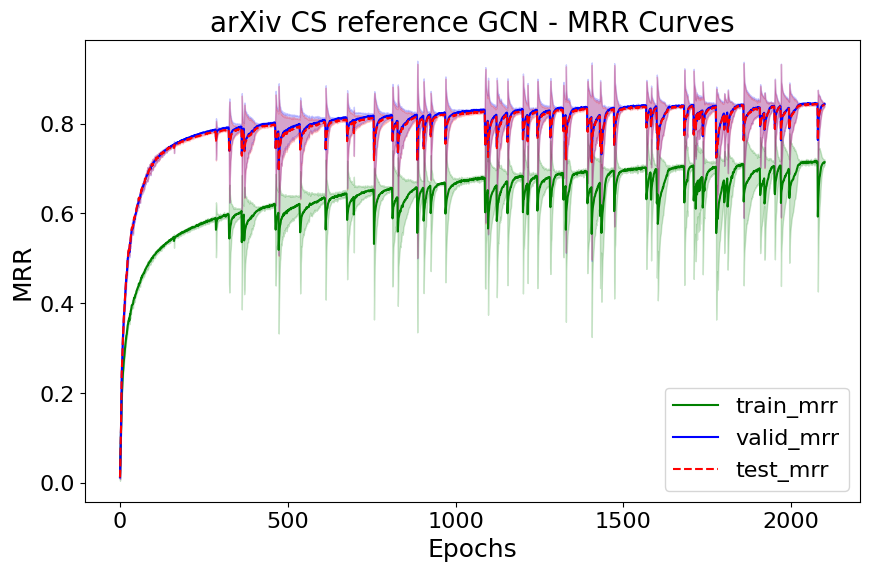

In [32]:
# plot the 5 runs with an interval
# Combine all runs into a single DataFrame
all_metrics = pd.concat([run['metrics'] for run in experiment_data])

# Convert metricValue to float
all_metrics['metricValue'] = all_metrics['metricValue'].astype(float)

# Group by epoch and metricName to calculate mean and std
agg_metrics = all_metrics.groupby(['epoch', 'metricName']).agg(
    mean_metricValue=('metricValue', 'mean'),
    std_metricValue=('metricValue', 'std')
).reset_index()

plt.figure(figsize=(10, 6))

# Plotting train_mrr with std
train_mrr = agg_metrics[agg_metrics['metricName'] == 'train_mrr']
sns.lineplot(data=train_mrr, x="epoch", y="mean_metricValue", label="train_mrr", color="green")
plt.fill_between(train_mrr['epoch'], 
                 train_mrr['mean_metricValue'] - train_mrr['std_metricValue'],
                 train_mrr['mean_metricValue'] + train_mrr['std_metricValue'],
                 color="green", alpha=0.2)

# Plotting valid_mrr with std
valid_mrr = agg_metrics[agg_metrics['metricName'] == 'valid_mrr']
sns.lineplot(data=valid_mrr, x="epoch", y="mean_metricValue", label="valid_mrr", color="blue")
plt.fill_between(valid_mrr['epoch'], 
                 valid_mrr['mean_metricValue'] - valid_mrr['std_metricValue'],
                 valid_mrr['mean_metricValue'] + valid_mrr['std_metricValue'],
                 color="blue", alpha=0.2)

# Plotting valid_mrr with std
test_mrr = agg_metrics[agg_metrics['metricName'] == 'test_mrr']
sns.lineplot(data=test_mrr, x="epoch", y="mean_metricValue", label="test_mrr",linestyle="dashed", color="red")
plt.fill_between(test_mrr['epoch'], 
                 test_mrr['mean_metricValue'] - test_mrr['std_metricValue'],
                 test_mrr['mean_metricValue'] + test_mrr['std_metricValue'],
                 color="red", alpha=0.2)


plt.xlabel('Epochs')
plt.ylabel('MRR')
plt.title('arXiv CS reference GCN - MRR Curves')
plt.legend()
plt.show()


## Finetuning (Transfer Learning Metrics)
Calculation the transfer metrics jumpstar, asymptotic performance and transfer ratio.

In [33]:
# test_mrr_mean is the mean of the best epochs of the reference model
jumpstart_test_gcn = firstepoch_test_mrr_gcn_fine - firstepoch_test_mrr_gcn_ref
asyperf_test_gcn = finalepoch_test_mrr_gcn_fine - test_mrr_mean
transferratio_test_gcn = (finalepoch_test_mrr_gcn_fine - test_mrr_mean) / test_mrr_mean

jumpstart_test_ngcn =  firstepoch_test_mrr_ngcn_fine - firstepoch_test_mrr_ngcn_ref
asyperf_test_ngcn = finalepoch_test_mrr_ngcn_fine - finalepoch_test_mrr_ngcn_ref
transferratio_test_ngcn = (finalepoch_test_mrr_ngcn_fine - finalepoch_test_mrr_ngcn_ref) / finalepoch_test_mrr_ngcn_ref

## Other Visualisations
Further visualisations used for the thesis.

In [34]:
def plot_training_curves(path_mrr_curves,title="MRR Curves",visualize_test_mrr =True):
    with open(path_mrr_curves, 'r') as f:
        arxiv_cs_mrr_data = json.load(f)
    arxiv_cs_mrr_df = pd.DataFrame(arxiv_cs_mrr_data)
    plt.figure(figsize=(10, 6))
    for curve in range(len(arxiv_cs_mrr_df)):
        if visualize_test_mrr and arxiv_cs_mrr_df.iloc[curve]['name'] == "test_mrr":
            plt.plot(arxiv_cs_mrr_df.iloc[curve]['x'], arxiv_cs_mrr_df.iloc[curve]['y'], label=arxiv_cs_mrr_df.iloc[curve]['name'],linestyle="dashed",color="red",alpha=0.7)
        elif arxiv_cs_mrr_df.iloc[curve]['name'] == "train_mrr":
            plt.plot(arxiv_cs_mrr_df.iloc[curve]['x'], arxiv_cs_mrr_df.iloc[curve]['y'], label=arxiv_cs_mrr_df.iloc[curve]['name'],color ="green")
        elif arxiv_cs_mrr_df.iloc[curve]['name'] == "valid_mrr":
            plt.plot(arxiv_cs_mrr_df.iloc[curve]['x'], arxiv_cs_mrr_df.iloc[curve]['y'], label=arxiv_cs_mrr_df.iloc[curve]['name'],color ="blue")


    plt.xlabel('Epochs')
    plt.ylabel('MRR')
    plt.title(title)
    plt.legend()
    plt.show()

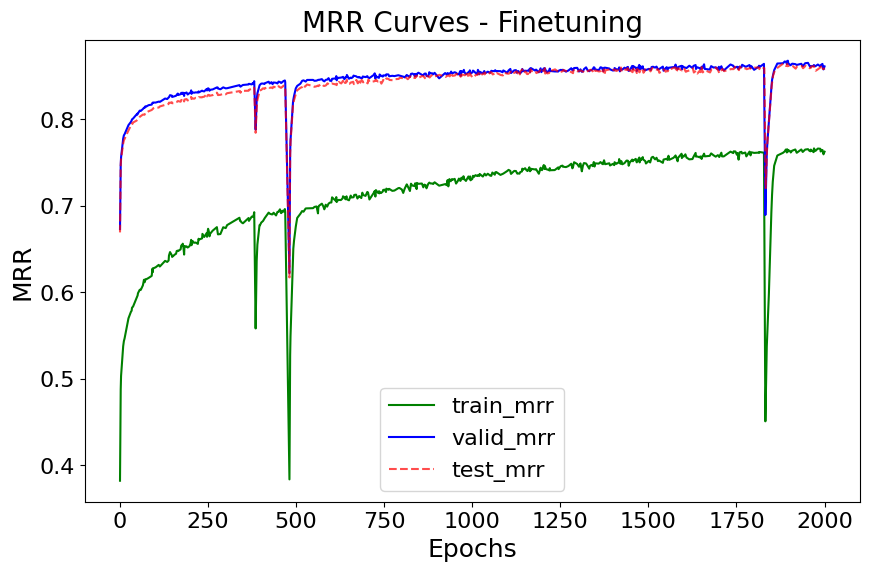

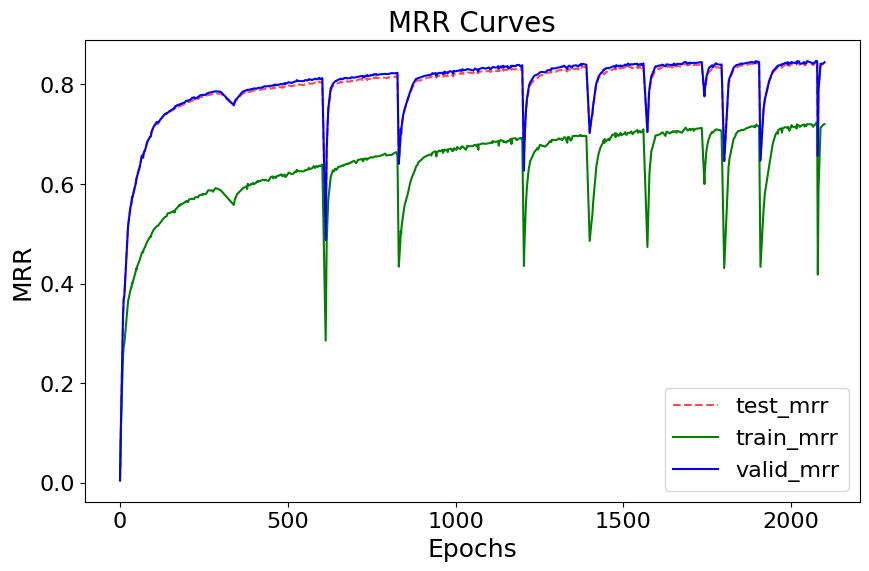

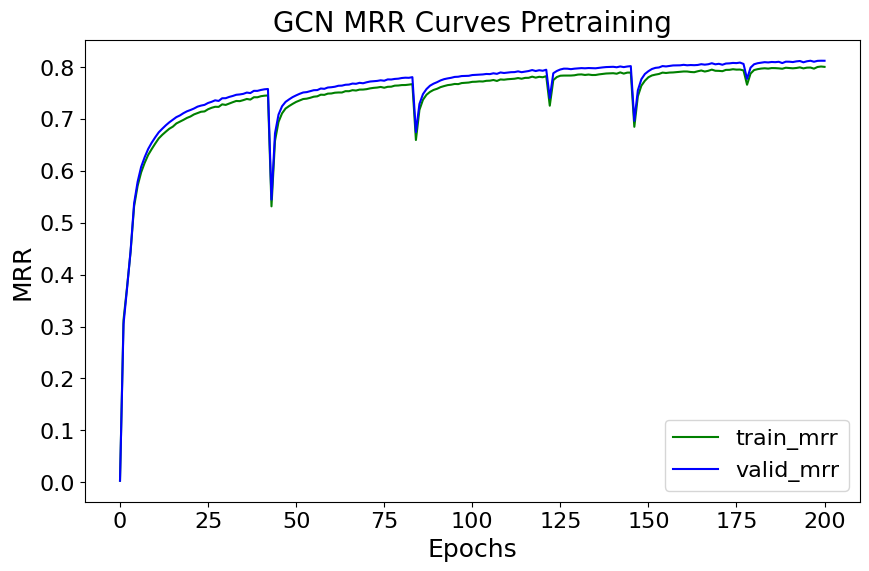

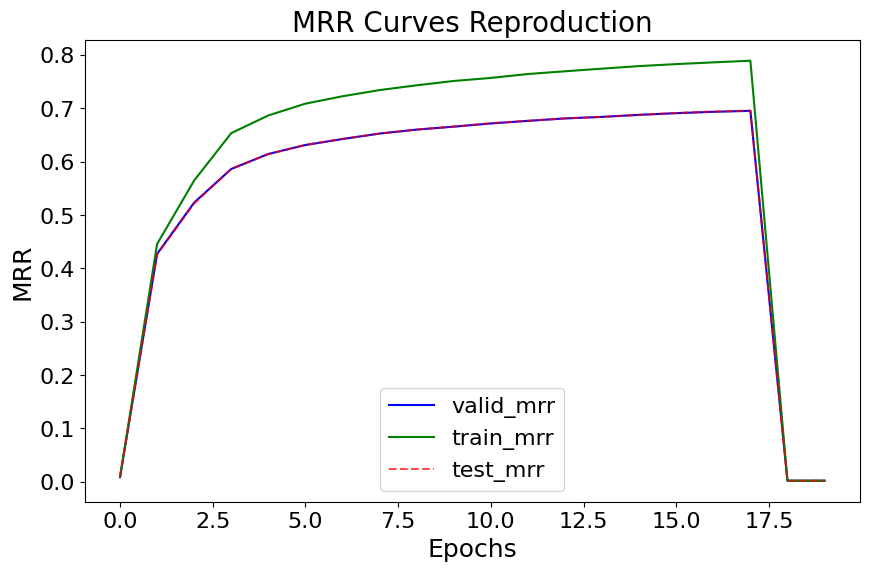

In [35]:
plot_training_curves('./training_curve_data/finetuning_reference_hyperparameters_tuned.json',"MRR Curves - Finetuning",True)
plot_training_curves('./training_curve_data/arxiv_cs_mrr_curves.json')
plot_training_curves('./training_curve_data/pretraining_mrr_curves.json',"GCN MRR Curves Pretraining",visualize_test_mrr=False)
plot_training_curves('./training_curve_data/reproduction_mrr_curve.json',"MRR Curves Reproduction")